<a href="https://colab.research.google.com/github/AritraStark/E2E_GSOC_2022/blob/main/E2E_eval_task_1_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Common Task 1. Electron/photon classification**

**Datasets:**

https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc (photons)

https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA (electrons)

**Description:** 32x32 matrices (two channels - hit energy and time) for two classes of particles electrons and photons impinging on a calorimeter Please use a deep learning method of your choice to achieve the highest possible classification on this dataset (we ask that you do it both in Keras/Tensorflow and in PyTorch). Please provide a Jupyter notebook that shows your solution. The model yousubmit should have a ROC AUC score of at least 0.80.



Downloading the dataset: 

In [1]:
!wget https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download -O photons.hdf5
!wget https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download -O electrons.hdf5

--2022-04-04 12:16:47--  https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 137.138.120.151, 128.142.170.17, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119703858 (114M) [application/octet-stream]
Saving to: ‘photons.hdf5’

photons.hdf5        100%[===================>] 114.16M   119MB/s    in 1.0s    

Last-modified header invalid -- time-stamp ignored.
2022-04-04 12:16:49 (119 MB/s) - ‘photons.hdf5’ saved [119703858/119703858]

--2022-04-04 12:16:49--  https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 137.138.120.151, 128.142.170.17, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128927319 (123M) [application/octet-stream]
Saving to: ‘electrons.hdf5’

elec

Defining the imports:

In [10]:
import torch
from torch.utils.data import DataLoader,TensorDataset
from torch import Tensor
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pandas as pd
from tqdm import tqdm
import gc
from sklearn.metrics import auc, roc_curve, roc_auc_score

Extracting the data and flattening it:

In [3]:
X_electron = np.array(h5py.File("electrons.hdf5",'r').get(name="X")[()])
y_electron = np.array(h5py.File("electrons.hdf5",'r').get(name="y")[()])
X_photon = np.array(h5py.File("photons.hdf5",'r').get(name="X")[()])
y_photon = np.array(h5py.File("photons.hdf5",'r').get(name="y")[()])

X_particles = np.concatenate((X_electron,X_photon),axis=0)
y_particles = np.concatenate((y_electron,y_photon),axis=0)
print(X_particles.shape,y_particles.shape)

del X_electron
del X_photon
del y_electron
del y_photon

index = np.random.permutation(len(y_particles))
X_particles, y_particles = X_particles[index][:,:,:,0].reshape((-1,32*32)), y_particles[index]


(498000, 32, 32, 2) (498000,)


Defining the dataloaders and tensors from the extracted data:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_particles, y_particles, test_size=0.2, random_state=12)
del X_particles, y_particles

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=200)

train_set = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train.reshape((-1,1))))
valid_set = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid.reshape((-1,1))))
test_set = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test.reshape((-1,1))))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((318720, 1024), (99600, 1024), (318720,), (99600,))

Defining the model:

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.linear_stack = nn.Sequential(
            # layer 1
            nn.Linear(32*32, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            # layer 2
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            # layer 3
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            # layer 4
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            # output layer
            nn.Linear(256,1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits


Training and evaluating the model:

In [6]:
model = FCN().to(device)
print(model)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 30
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    train_correct = 0
    model.train()
    for data, labels in tqdm(train_loader):
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = model(data)    
        # Find the Loss
        loss = criterion(target,labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
        # Calculate Correct
        train_correct += ((target>0.5).float() == labels).sum().item()
    scheduler.step()
    
    valid_loss = 0.0
    val_correct = 0
    model.eval()     # Optional when not using Model Specific layer
    for data, labels in valid_loader:
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target,labels)
        # Calculate Loss
        valid_loss += loss.item()
        # Calculate Right Prediction
        val_correct += ((target>0.5).float() == labels).sum().item()
 
    print('Epoch: {}: \t Training Loss:{:.6f}\t Training Accuracy:{:.6f} \t Validation Loss:{:.6f} \t Validation Accuracy:{:.6f}'.format(
        e+1, train_loss / len(train_loader), train_correct*1.0 / len(X_train), valid_loss / len(valid_loader), val_correct*1.0 / len(X_valid)
    ))
     
    if min_valid_loss > valid_loss:
        min_valid_loss = valid_loss
         
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')

FCN(
  (linear_stack): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


100%|██████████| 9960/9960 [02:31<00:00, 65.55it/s]


Epoch: 1: 	 Training Loss:0.618143	 Training Accuracy:0.667112 	 Validation Loss:0.596270 	 Validation Accuracy:0.691428


100%|██████████| 9960/9960 [02:34<00:00, 64.50it/s]


Epoch: 2: 	 Training Loss:0.592857	 Training Accuracy:0.696856 	 Validation Loss:0.576877 	 Validation Accuracy:0.708032


100%|██████████| 9960/9960 [02:38<00:00, 62.99it/s]


Epoch: 3: 	 Training Loss:0.585612	 Training Accuracy:0.704148 	 Validation Loss:0.573113 	 Validation Accuracy:0.711760


100%|██████████| 9960/9960 [02:31<00:00, 65.65it/s]


Epoch: 4: 	 Training Loss:0.580640	 Training Accuracy:0.706899 	 Validation Loss:0.566282 	 Validation Accuracy:0.716792


100%|██████████| 9960/9960 [02:44<00:00, 60.39it/s]


Epoch: 5: 	 Training Loss:0.576159	 Training Accuracy:0.711483 	 Validation Loss:0.563521 	 Validation Accuracy:0.719842


100%|██████████| 9960/9960 [03:04<00:00, 53.90it/s]


Epoch: 6: 	 Training Loss:0.573449	 Training Accuracy:0.712889 	 Validation Loss:0.563160 	 Validation Accuracy:0.719716


100%|██████████| 9960/9960 [03:36<00:00, 46.01it/s]


Epoch: 7: 	 Training Loss:0.571209	 Training Accuracy:0.715230 	 Validation Loss:0.560708 	 Validation Accuracy:0.720708


100%|██████████| 9960/9960 [03:52<00:00, 42.79it/s]


Epoch: 8: 	 Training Loss:0.568449	 Training Accuracy:0.717153 	 Validation Loss:0.560777 	 Validation Accuracy:0.721787


100%|██████████| 9960/9960 [03:56<00:00, 42.13it/s]


Epoch: 9: 	 Training Loss:0.566844	 Training Accuracy:0.717824 	 Validation Loss:0.557343 	 Validation Accuracy:0.723268


100%|██████████| 9960/9960 [03:59<00:00, 41.61it/s]


Epoch: 10: 	 Training Loss:0.564258	 Training Accuracy:0.719748 	 Validation Loss:0.556290 	 Validation Accuracy:0.725138


100%|██████████| 9960/9960 [03:58<00:00, 41.80it/s]


Epoch: 11: 	 Training Loss:0.563389	 Training Accuracy:0.720796 	 Validation Loss:0.557920 	 Validation Accuracy:0.724448


100%|██████████| 9960/9960 [03:59<00:00, 41.53it/s]


Epoch: 12: 	 Training Loss:0.561667	 Training Accuracy:0.721646 	 Validation Loss:0.555332 	 Validation Accuracy:0.723783


100%|██████████| 9960/9960 [04:00<00:00, 41.35it/s]


Epoch: 13: 	 Training Loss:0.560828	 Training Accuracy:0.722575 	 Validation Loss:0.553890 	 Validation Accuracy:0.725728


100%|██████████| 9960/9960 [03:59<00:00, 41.65it/s]


Epoch: 14: 	 Training Loss:0.559103	 Training Accuracy:0.724024 	 Validation Loss:0.553463 	 Validation Accuracy:0.726305


100%|██████████| 9960/9960 [04:00<00:00, 41.46it/s]


Epoch: 15: 	 Training Loss:0.558789	 Training Accuracy:0.723877 	 Validation Loss:0.554335 	 Validation Accuracy:0.726368


100%|██████████| 9960/9960 [04:00<00:00, 41.45it/s]


Epoch: 16: 	 Training Loss:0.557686	 Training Accuracy:0.725295 	 Validation Loss:0.552530 	 Validation Accuracy:0.725879


100%|██████████| 9960/9960 [03:59<00:00, 41.57it/s]


Epoch: 17: 	 Training Loss:0.556037	 Training Accuracy:0.726428 	 Validation Loss:0.552634 	 Validation Accuracy:0.726130


100%|██████████| 9960/9960 [04:01<00:00, 41.31it/s]


Epoch: 18: 	 Training Loss:0.555917	 Training Accuracy:0.726402 	 Validation Loss:0.551446 	 Validation Accuracy:0.727171


100%|██████████| 9960/9960 [04:01<00:00, 41.21it/s]


Epoch: 19: 	 Training Loss:0.555182	 Training Accuracy:0.726926 	 Validation Loss:0.550684 	 Validation Accuracy:0.726657


100%|██████████| 9960/9960 [04:01<00:00, 41.18it/s]


Epoch: 20: 	 Training Loss:0.554678	 Training Accuracy:0.726977 	 Validation Loss:0.551618 	 Validation Accuracy:0.727460


100%|██████████| 9960/9960 [04:02<00:00, 41.08it/s]


Epoch: 21: 	 Training Loss:0.553378	 Training Accuracy:0.728583 	 Validation Loss:0.551290 	 Validation Accuracy:0.726983


100%|██████████| 9960/9960 [04:04<00:00, 40.75it/s]


Epoch: 22: 	 Training Loss:0.553190	 Training Accuracy:0.728432 	 Validation Loss:0.550788 	 Validation Accuracy:0.727146


100%|██████████| 9960/9960 [04:04<00:00, 40.70it/s]


Epoch: 23: 	 Training Loss:0.552476	 Training Accuracy:0.728696 	 Validation Loss:0.551117 	 Validation Accuracy:0.726732


100%|██████████| 9960/9960 [04:04<00:00, 40.79it/s]


Epoch: 24: 	 Training Loss:0.552113	 Training Accuracy:0.729248 	 Validation Loss:0.551756 	 Validation Accuracy:0.726920


100%|██████████| 9960/9960 [04:02<00:00, 41.05it/s]


Epoch: 25: 	 Training Loss:0.551497	 Training Accuracy:0.729267 	 Validation Loss:0.550105 	 Validation Accuracy:0.727786


100%|██████████| 9960/9960 [04:02<00:00, 41.06it/s]


Epoch: 26: 	 Training Loss:0.550926	 Training Accuracy:0.729882 	 Validation Loss:0.549985 	 Validation Accuracy:0.728200


100%|██████████| 9960/9960 [04:02<00:00, 41.12it/s]


Epoch: 27: 	 Training Loss:0.550875	 Training Accuracy:0.729571 	 Validation Loss:0.551014 	 Validation Accuracy:0.728426


100%|██████████| 9960/9960 [04:02<00:00, 41.07it/s]


Epoch: 28: 	 Training Loss:0.550637	 Training Accuracy:0.730205 	 Validation Loss:0.550737 	 Validation Accuracy:0.727585


100%|██████████| 9960/9960 [04:01<00:00, 41.22it/s]


Epoch: 29: 	 Training Loss:0.550578	 Training Accuracy:0.730296 	 Validation Loss:0.550022 	 Validation Accuracy:0.728025


100%|██████████| 9960/9960 [04:01<00:00, 41.21it/s]


Epoch: 30: 	 Training Loss:0.550549	 Training Accuracy:0.730155 	 Validation Loss:0.549719 	 Validation Accuracy:0.729142


Testing the model on test data: 

In [7]:
def test(model, test_loader):
    total = 0
    correct = 0
    model.eval()     # Optional when not using Model Specific layer
    y_pred = np.array([])
    with torch.no_grad():
        for data, labels in test_loader:
            # Transfer Data to GPU if available
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            # Forward Pass
            target = model(data)
            # Calculate Right Prediction
            total += labels.size(0)
            correct += ((target>0.5).float() == labels).sum().item()
            # Save prediction
            y_pred = np.append(y_pred, target.cpu().detach().numpy())
    gc.collect()
    print('Testing Accuracy:{:.6f}'.format(correct*1.0 / total))
    return y_pred

Saving the model and getting the predictions:

In [8]:
best_model = FCN()
best_model.load_state_dict(torch.load("saved_model.pth"))
best_model.to(device)
y_pred = test(best_model, test_loader)

Testing Accuracy:0.727299


ROC AUC score and curve:

ROC AUC: 0.7944780046558753


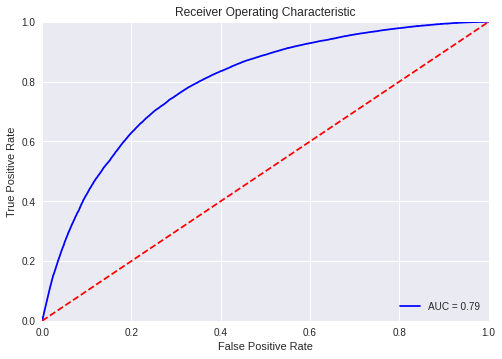

In [15]:
print("ROC AUC:" ,roc_auc_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()